# Project: **Finding Lane Lines on the Road** 


The goal of this project is to identify and highlight lane lines on the road.

---

<figure>
 <img src="examples/solidWhiteRight.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The goal is to take an image (shown above)</p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> And connect/average/extrapolate line segments to identify the lane lines</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
# Set Up Environment
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import math

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


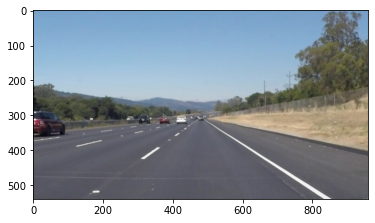

In [162]:
# Reading one of the example images
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Printing out some stats and displaying the image
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to use throughout the project

In [109]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function will take the image and lines identified by the hough_lines function
    and create / extrapolate an average of all lines to make up the left and right
    lane lines
    """            
    negative_slopes = []
    positive_slopes = []
    negetive_intercepts = []
    positive_intercepts = []
    
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    y_max = img.shape[0]
    y_min = img.shape[0]

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            # Append Left Lines to negative_slopes[]
            if slope < 0.0:
                negative_slopes.append(slope)
                left_line_x.append(x1)
                left_line_x.append(x2)
                left_line_y.append(y1)
                left_line_y.append(y2)
                negetive_intercepts.append(y1 - slope*x1)
            
            # Append Right Lines to positive_slopes[]
            if slope > 0.0:
                positive_slopes.append(slope)
                right_line_x.append(x1)
                right_line_x.append(x2)
                right_line_y.append(y1)
                right_line_y.append(y2)
                positive_intercepts.append(y1 - slope*x1)
                
            y_min = min(y_min, y1, y2)
    
    if len(positive_slopes) > 0 and len(right_line_x) > 0 and len(right_line_y) > 0:
        ave_positive_slope = sum(positive_slopes) / len(positive_slopes)
        ave_right_line_x = sum(right_line_x) / len(right_line_x)
        ave_right_line_y = sum(right_line_y ) / len(right_line_y)
        intercept = sum(positive_intercepts) / len(positive_intercepts)    
        x_min=int((y_min-intercept)/ave_positive_slope) 
        x_max = int((y_max - intercept)/ ave_positive_slope)
        cv2.line(img, (x_min, y_min), (x_max, y_max), [255, 0, 0], 10)

    if len(negative_slopes) > 0 and len(left_line_x) > 0 and len(left_line_y) > 0:
        ave_negative_slope = sum(negative_slopes) / len(negative_slopes)
        ave_left_line_x = sum(left_line_x) / len(left_line_x)
        ave_left_line_y = sum(left_line_y ) / len(left_line_y)
        intercept = sum(negetive_intercepts) / len(negetive_intercepts)
        x_min = int((y_min-intercept)/ave_negative_slope) 
        x_max = int((y_max - intercept)/ ave_negative_slope)
        cv2.line(img, (x_min, y_min), (x_max, y_max), [255, 0, 0], 10)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform   
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



The general approach will be as follows:
1. Convert the image to grayscale with grayscale() function
2. Use that image to create gaussian image with guassian_blur() function
3. Use that image to identify edges with canny() function
4. Identify the region of interest with region_of_interest() function
5. Hough transform the region of interest with hough_lines() function
6. Finally return the weighted image with weighted_img() function

## 1. Convert the image to grayscale with grayscale() function

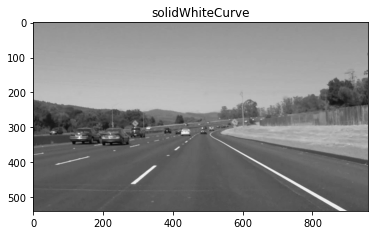

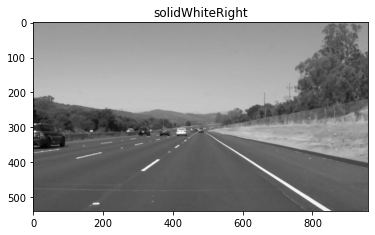

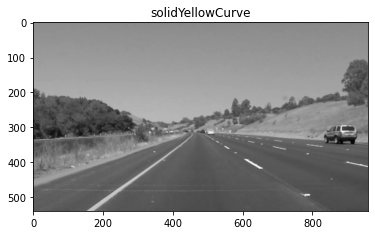

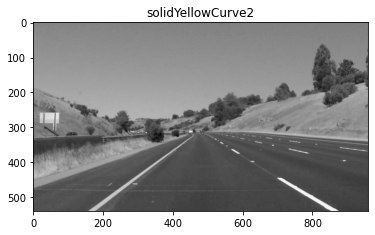

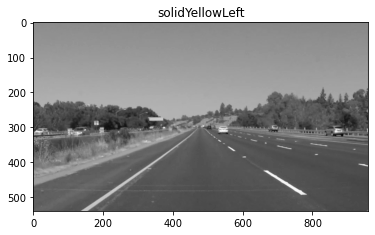

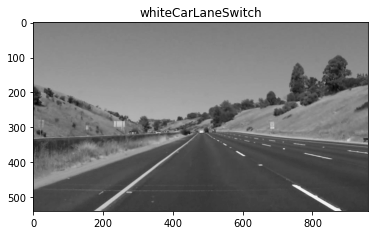

In [165]:
# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    plt.imshow(grayscale(img), cmap='gray')
    plt.title(image[:-4])
    plt.show()

## 2. Use that image to create gaussian image with guassian_blur() function

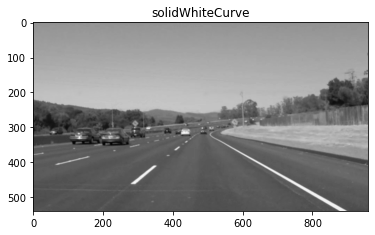

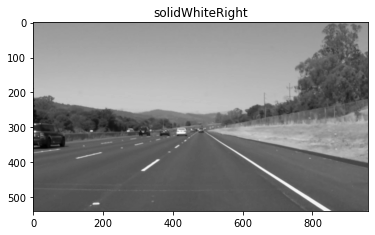

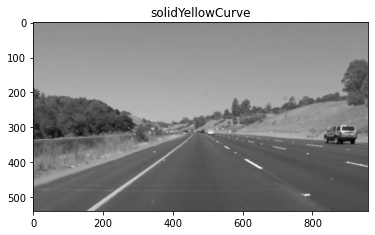

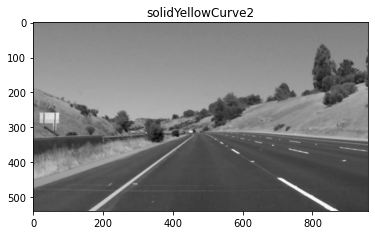

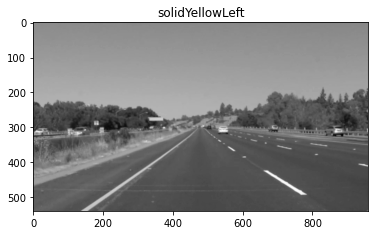

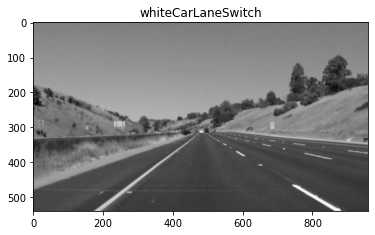

In [166]:
# Constant used in gaussian_blur() function below
kernel_size = 3

# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    grayscale_image = grayscale(img)
    gaussian_blur_image = gaussian_blur(grayscale_image, kernel_size)
    plt.imshow(gaussian_blur_image, cmap='gray')
    plt.title(image[:-4])
    plt.show()

## 3. Use that image to identify edges with canny() function

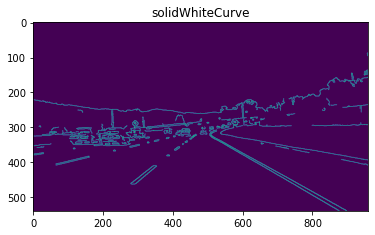

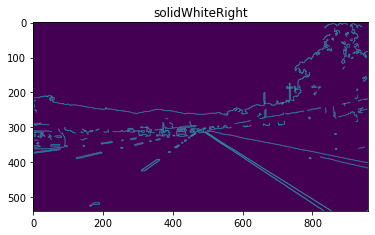

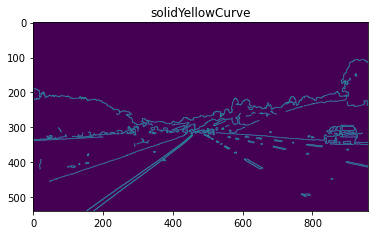

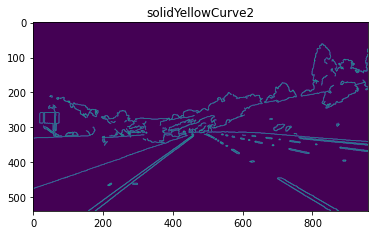

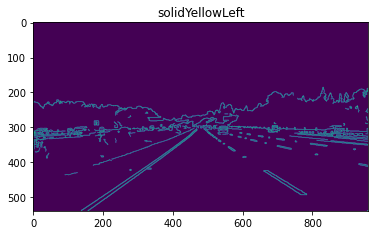

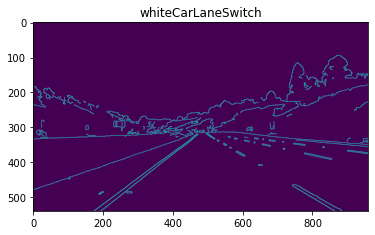

In [167]:
# Constants that will be used in canny() function below
low_threshold = 75 # threshold for canny edge detector
high_threshold = 150 # threshold for canny edge detector

# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)    
    grayscale_image = grayscale(img)
    gaussian_blur_image = gaussian_blur(grayscale_image, kernel_size)
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold)
    plt.imshow(canny_image)
    plt.title(image[:-4])
    plt.show()

## 4. Identify the region of interest with region_of_interest() function

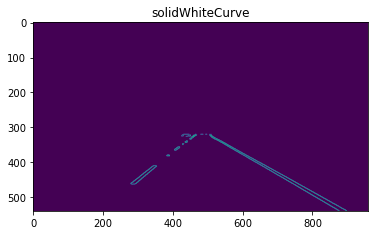

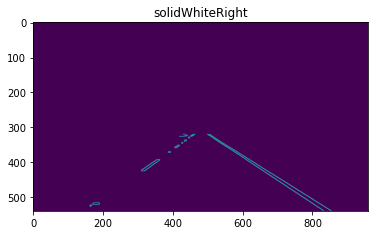

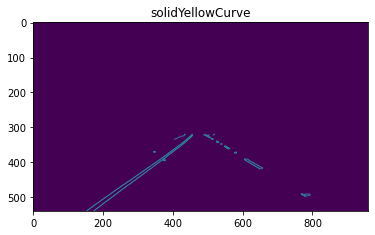

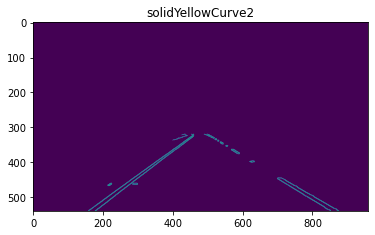

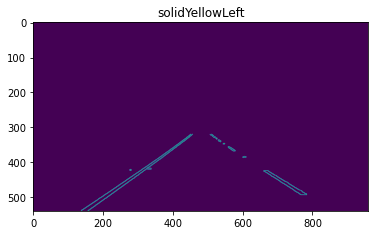

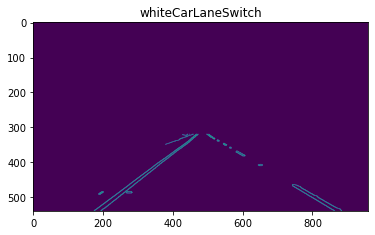

In [168]:
# Constants that will be used in vertices below
bottom_shift = 50 # use for creating area of interest region
top_shift = 50 # use for creating area of interest region

# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    grayscale_image = grayscale(img)
    gaussian_blur_image = gaussian_blur(grayscale_image, kernel_size)
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold)
    
    image_height = img.shape[0]
    image_width = img.shape[1]
    
    vertices = np.array([[(bottom_shift, image_height),
                        (image_width / 2 - top_shift, image_height / 2 + top_shift), 
                        (image_width /2 + top_shift, image_height / 2 + top_shift),
                        (image_width - bottom_shift, image_height)]], dtype=np.int32)
    
    region_image = region_of_interest(canny_image, vertices)
    
    plt.imshow(region_image)
    plt.title(image[:-4])
    plt.show()

## 5a. Hough transform the region of interest with hough_lines() function
This first pass will highlight the lines identified in the region of interest

In [139]:
def initial_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def initial_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    initial_lines(line_img, lines)
    return line_img

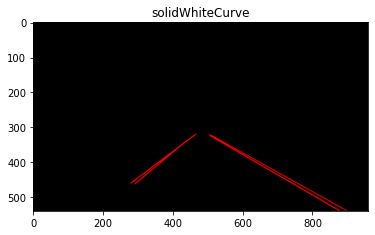

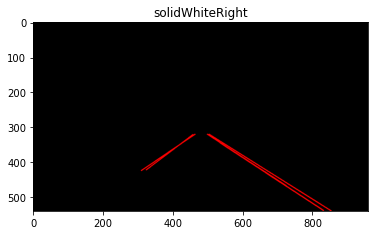

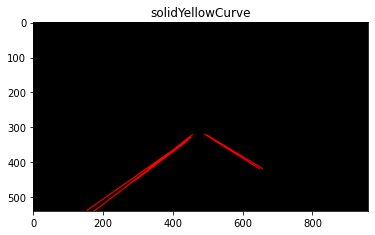

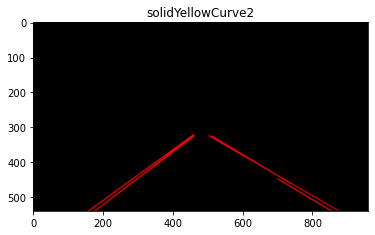

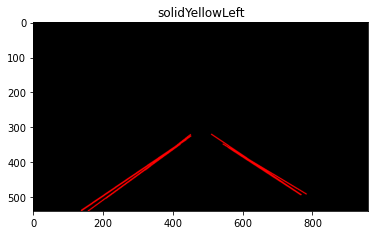

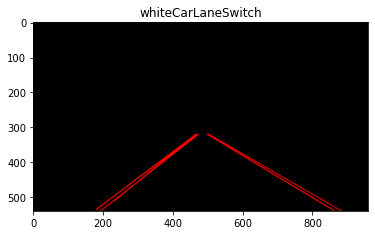

In [169]:
# Constants that will be used in vertices below
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
min_votes = 100    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 15 #minimum number of pixels making up a line
max_line_gap = 100   # maximum gap in pixels between connectable line segments 

# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    grayscale_image = grayscale(img)
    gaussian_blur_image = gaussian_blur(grayscale_image, kernel_size)
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold)
    
    image_height = img.shape[0]
    image_width = img.shape[1]
    
    vertices = np.array([[(bottom_shift, image_height),
                        (image_width / 2 - top_shift, image_height / 2 + top_shift), 
                        (image_width /2 + top_shift, image_height / 2 + top_shift),
                        (image_width - bottom_shift, image_height)]], dtype=np.int32)
    
    region_image = region_of_interest(canny_image, vertices)
    
    hough_image = initial_hough_lines(region_image, rho, theta, min_votes, min_line_len, max_line_gap)
    
    plt.imshow(hough_image)
    plt.title(image[:-4])
    plt.show()

## 5b. Hough transform the region of interest with hough_lines() function
This next pass will use the draw_lines() function to extrapolate and combine the smaller lines. This is will create one thicker line for the left and right lane lines which will be used to overlay on the original image.

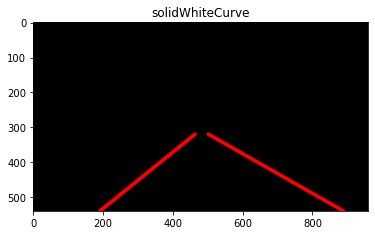

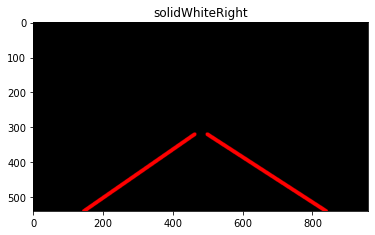

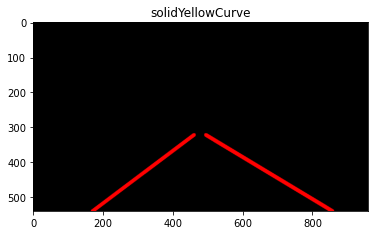

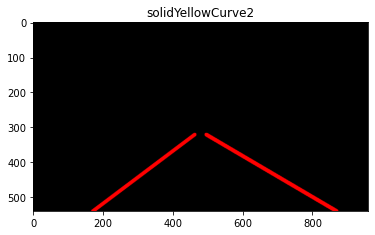

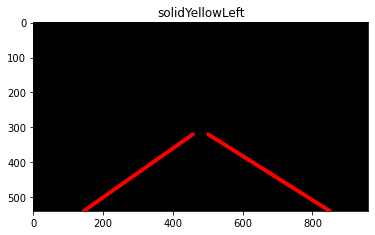

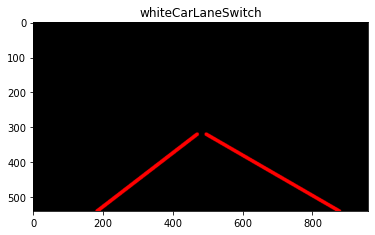

In [170]:
# Constants that will be used in vertices below
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
min_votes = 100    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 25 #minimum number of pixels making up a line
max_line_gap = 25   # maximum gap in pixels between connectable line segments 

# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    grayscale_image = grayscale(img)
    gaussian_blur_image = gaussian_blur(grayscale_image, kernel_size)
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold)
    
    image_height = img.shape[0]
    image_width = img.shape[1]
    
    vertices = np.array([[(bottom_shift, image_height),
                        (image_width / 2 - top_shift, image_height / 2 + top_shift), 
                        (image_width /2 + top_shift, image_height / 2 + top_shift),
                        (image_width - bottom_shift, image_height)]], dtype=np.int32)
    
    region_image = region_of_interest(canny_image, vertices)
    
    hough_image = hough_lines(region_image, rho, theta, min_votes, min_line_len, max_line_gap)
    
    plt.imshow(hough_image)
    plt.title(image[:-4])
    plt.show()

## 6. Finally return the weighted image with weighted_img() function

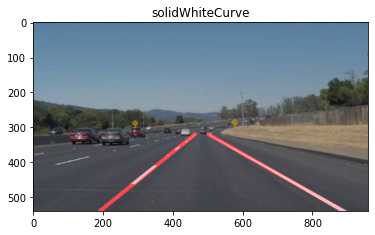

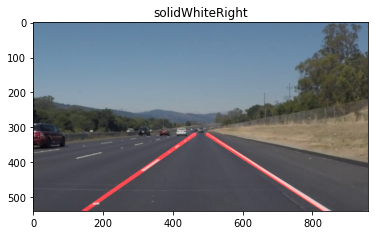

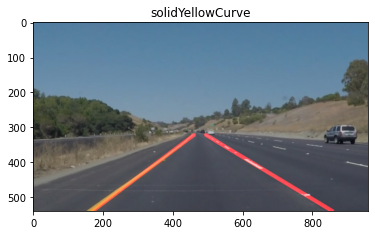

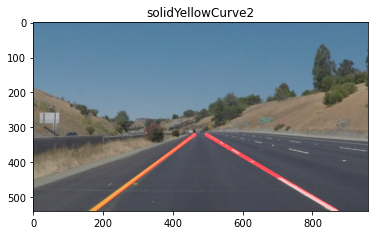

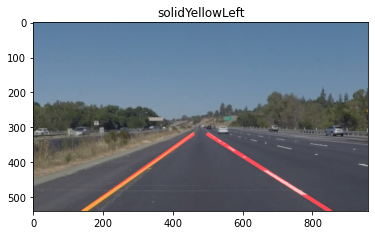

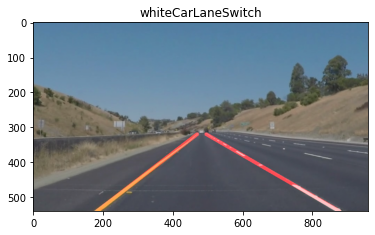

In [171]:
# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    grayscale_image = grayscale(img)
    gaussian_blur_image = gaussian_blur(grayscale_image, kernel_size)
    canny_image = canny(gaussian_blur_image, low_threshold, high_threshold)
    
    image_height = img.shape[0]
    image_width = img.shape[1]
    
    vertices = np.array([[(bottom_shift, image_height),
                        (image_width / 2 - top_shift, image_height / 2 + top_shift), 
                        (image_width /2 + top_shift, image_height / 2 + top_shift),
                        (image_width - bottom_shift, image_height)]], dtype=np.int32)
    
    region_image = region_of_interest(canny_image, vertices)
    
    hough_image = hough_lines(region_image, rho, theta, min_votes, min_line_len, max_line_gap)
    #weighted_img(hough_image, image)
    weighted_image = weighted_img(hough_image, img)
    
    plt.imshow(weighted_image)
    plt.title(image[:-4])
    plt.show()

## Putting it all together

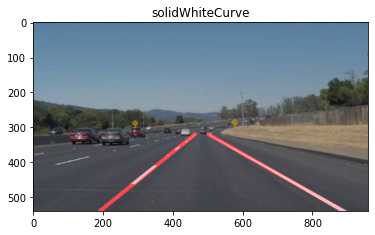

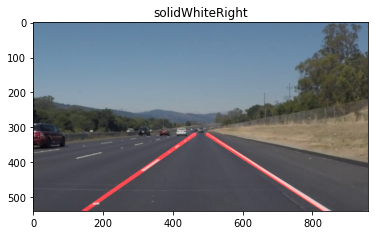

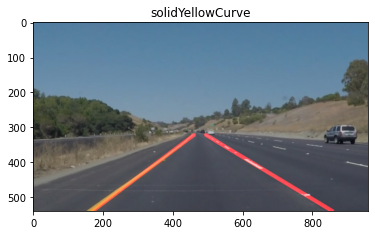

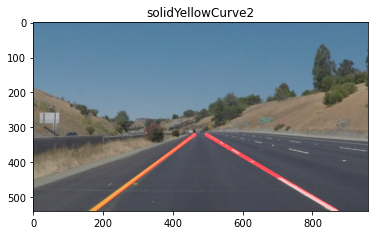

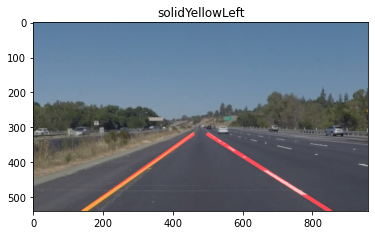

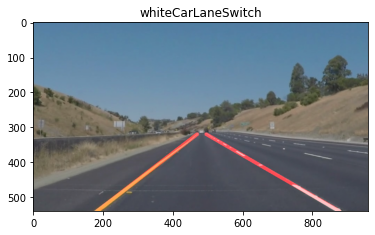

In [172]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def lane_lines_function(image):

# building the image processing pipeline
    grayscale_image = grayscale(image)
    
    smooth_image = gaussian_blur(grayscale_image, kernel_size)
    
    edges = canny(smooth_image, low_threshold, high_threshold)
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    vertices = np.array([[(bottom_shift, image_height),
                        (image_width / 2 - top_shift, image_height / 2 + top_shift), 
                        (image_width /2 + top_shift, image_height / 2 + top_shift),
                        (image_width - bottom_shift, image_height)]], dtype=np.int32)
    
    regions = region_of_interest(edges, vertices)
    
    hough_image = hough_lines(regions, rho, theta, min_votes, min_line_len, max_line_gap)
    return weighted_img(hough_image, image)


# Iterate through and show results on each image
for image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + image)
    plt.imshow(lane_lines_function(img))
    plt.title(image[:-4])
    plt.show()


## Test on Videos
This was performed on a local machine, visit video link in README.md to see video

In [150]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [151]:
def process_image(image):
    return lane_lines_function(image)

Let's try the video with the solid white lane on the right first

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline (it will also save the video file locally as well)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the video with the solid yellow lane on the left

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Finally iterate through all videos in folder and save the output

In [ ]:
# Iterate through and show results on each image
for image in os.listdir("test_videos/"):
    output = 'test_videos_output/'+image
    input = 'test_videos/'+image
    clip = VideoFileClip(input)
    new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time new_clip.write_videofile(output, audio=False)